In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import bnl
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Build the dataframe

In [45]:
for tid in bnl.fio.salami_tids():
    try:
        bnl.prf.compare_bmetrics_on_ests(tid)
    except:
        print(f"Error in {tid}")
        continue

/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Error in 11


/Users/xi/miniforge3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Error in 1568
Error in 679
Error in 710
Error in 711
Error in 714
Error in 716
Error in 717
Error in 719
Error in 720
Error in 724


In [52]:
# load all nc files from ./est_boundary_metrics, join them alone tid, and save the result as nc file
def load_and_join_nc_files():
    import glob
    import xarray as xr

    # Get all nc files in the directory
    nc_files = glob.glob("./est_boundary_metrics/*.nc")

    # Load all nc files into a list of DataFrames
    dataframes = [xr.open_dataset(nc_file) for nc_file in nc_files]

    # Concatenate all DataFrames along the 'tid' dimension
    # Ensure 'tid' is string type in each dataset before concatenation
    for ds in dataframes:
        if 'tid' in ds.coords and ds['tid'].dtype.kind in {'i', 'u'}:
            ds['tid'] = ds['tid'].astype(str)
    combined_df = xr.concat(dataframes, dim="tid")

    return combined_df

In [53]:
da = load_and_join_nc_files()

In [ ]:
df = da.to_dataframe(name='value').reset_index()
df_pivoted = df.pivot(index=['tid', 'window', "perf"], columns=["metric",  "mono_casting", "depth"], values='value')
df_pivoted.columns = [f'{metric}_{perf}' for metric, perf in df_pivoted.columns]
df_pivoted = df_pivoted.reset_index()

<xarray.Dataset> Size: 2MB
Dimensions:                        (tid: 1348, perf: 3, metric: 4, window: 2,
                                    mono_casting: 3, depth: 2)
Coordinates:
  * metric                         (metric) object 32B 'hr' 'sr' 'b' 't'
  * mono_casting                   (mono_casting) object 24B 'naive' ... 'bsc'
  * perf                           (perf) object 24B 'p' 'r' 'f'
  * depth                          (depth) object 16B 'default' '3'
  * window                         (window) object 16B '0.5' '3'
  * tid                            (tid) object 11kB '429' '18' ... '628' '768'
Data variables:
    __xarray_dataarray_variable__  (tid, perf, metric, window, mono_casting, depth) float64 2MB ...

## Just load:


In [3]:
df = pd.read_feather("est_boundary_metrics.feather")
df

tid window perf    depth      est_id anno_id  hr_naive  hr_absorb  \
0       10    0.5    f        3  mu1_gamma1       0  0.250000   0.375000   
1       10    0.5    f        3  mu1_gamma1       1  0.206186   0.273973   
2       10    0.5    f        3  mu1_gamma9       0  0.211765   0.214286   
3       10    0.5    f        3  mu1_gamma9       1  0.181818   0.172840   
4       10    0.5    f        3  mu5_gamma5       0  0.262295   0.347826   
...    ...    ...  ...      ...         ...     ...       ...        ...   
63283  999      3    r  default  mu1_gamma1       1  0.309524   0.309524   
63284  999      3    r  default  mu1_gamma9       0  0.272727   0.272727   
63285  999      3    r  default  mu1_gamma9       1  0.285714   0.261905   
63286  999      3    r  default  mu5_gamma5       0  0.409091   0.409091   
63287  999      3    r  default  mu5_gamma5       1  0.428571   0.428571   

         hr_bsc  sr_naive  sr_absorb    sr_bsc   b_naive  b_absorb     b_bsc  \
0      0.300000  0.750000   0.555556  0.444444  0.375000  0.447761  0.358209   
1      0.215385  0.600000   0.705882  0.750000  0.306905  0.394737  0.334661   
2      0.260870  0.470588   0.444444  0.444444  0.292089  0.289157  0.328767   
3      0.225352  0.400000   0.666667  0.600000  0.250000  0.274510  0.327645   
4      0.300000  0.740741   0.533333  0.444444  0.387409  0.421053  0.358209   
...         ...       ...        ...       ...       ...       ...       ...   
63283  0.309524  0.527778   0.583333  0.750000  0.390205  0.404444  0.438202   
63284  0.227273  0.914286   0.942857  0.880000  0.420131  0.423077  0.361248   
63285  0.238095  0.828571   0.766667  1.000000  0.424908  0.390432  0.384615   
63286  0.386364  0.707692   0.892308  0.766667  0.518472  0.560989  0.513798   
63287  0.428571  0.493827   0.518519  0.802469  0.458891  0.469274  0.558739   

        t_naive  t_absorb     t_bsc  
0      0.409251  0.414757  0.448953  
1      0.465334  0.468662  0.510263  
2      0.434619  0.441267  0.572876  
3      0.443519  0.450308  0.561110  
4      0.412629  0.418325  0.465529  
...         ...       ...       ...  
63283  0.839384  0.839404  0.899819  
63284  0.897221  0.896880  0.936050  
63285  0.878240  0.877959  0.914382  
63286  0.681256  0.681434  0.706923  
63287  0.771356  0.770834  0.867563  

[63288 rows x 18 columns]

## Figure 1:

Weak baseline is naive
Strong baseline is absorb
Gaussian Kernel is gaussian

Compare without level casting, T-measure and B-measure

Let's first see how the monocasting schemes affect T-measure. We should expect little effect


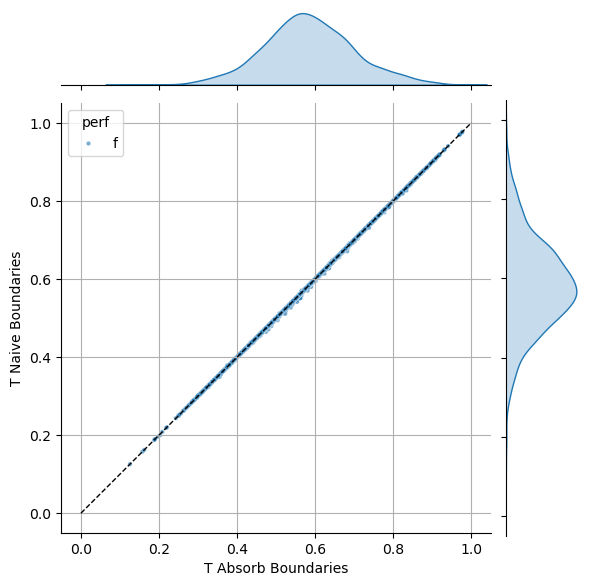

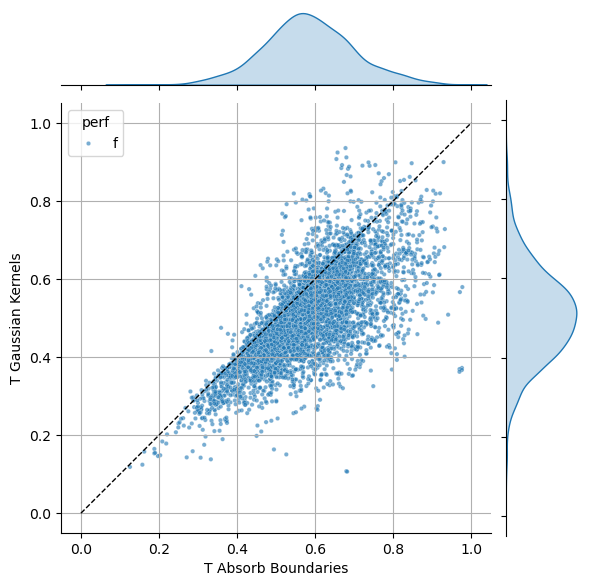

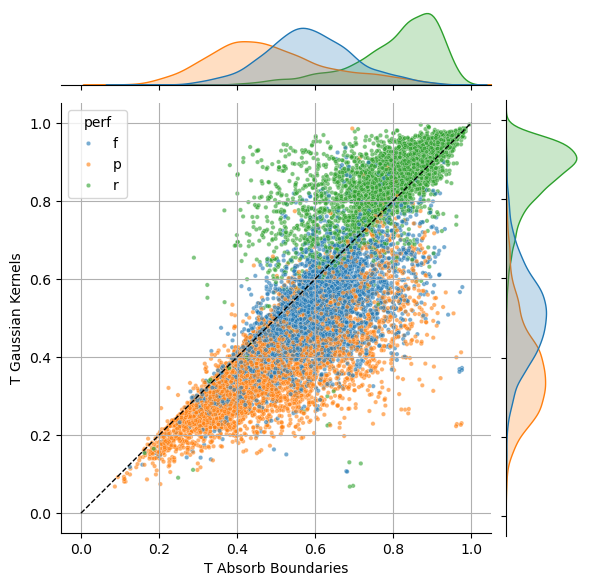

In [16]:
sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="t_absorb", y="t_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="T Absorb Boundaries", ylabel="T Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="t_absorb", y="t_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="T Absorb Boundaries", ylabel="T Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default"'), 
    x="t_absorb", y="t_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="T Absorb Boundaries", ylabel="T Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


## Figure 2: See mono casting's effect on B measure

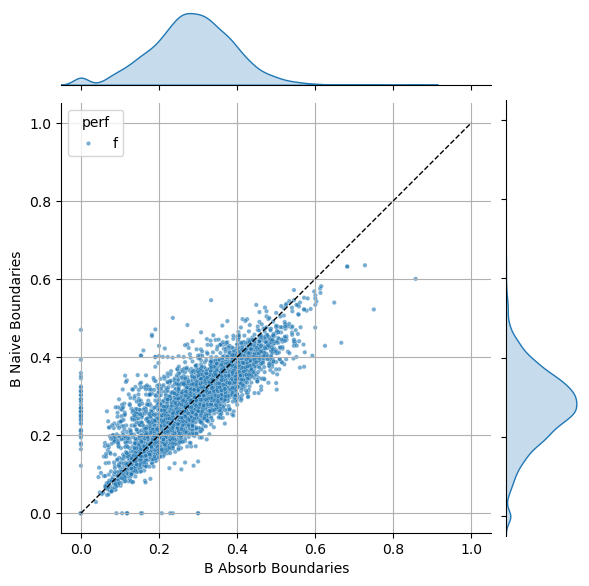

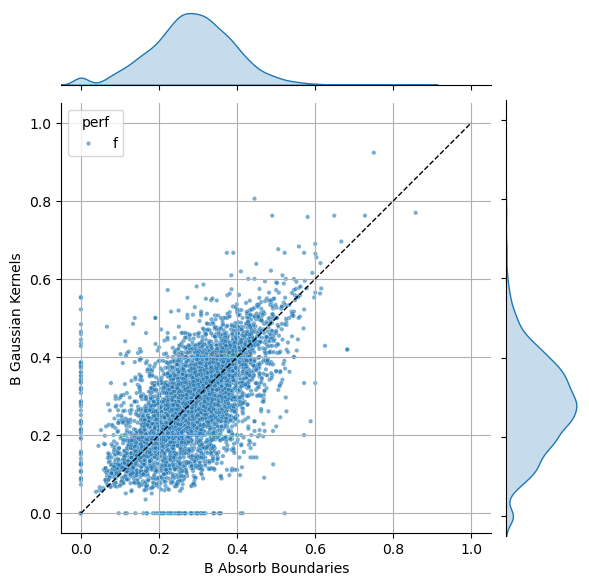

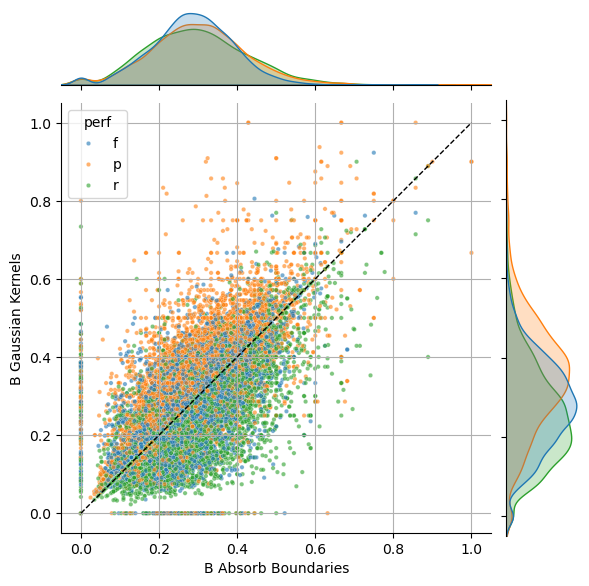

In [17]:
sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="b_absorb", y="b_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="b_absorb", y="b_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default"'), 
    x="b_absorb", y="b_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


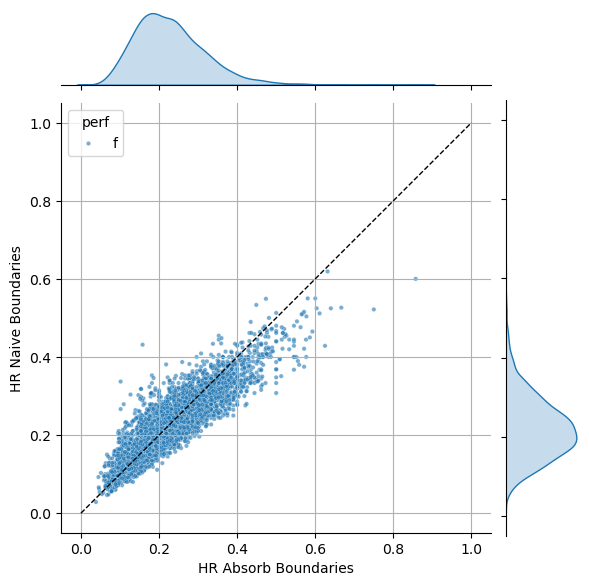

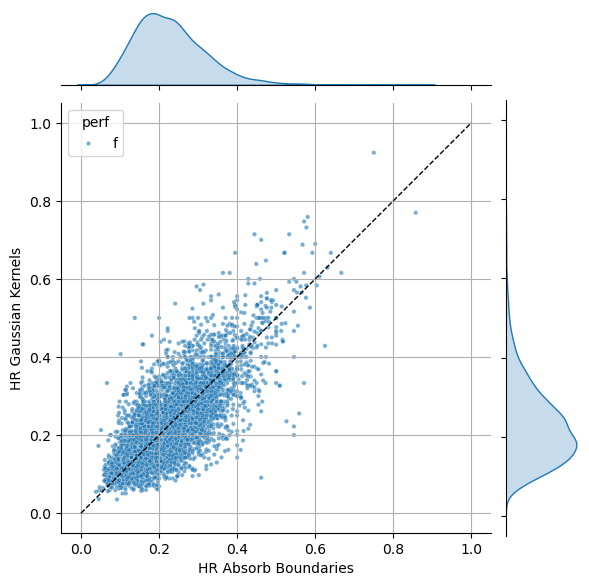

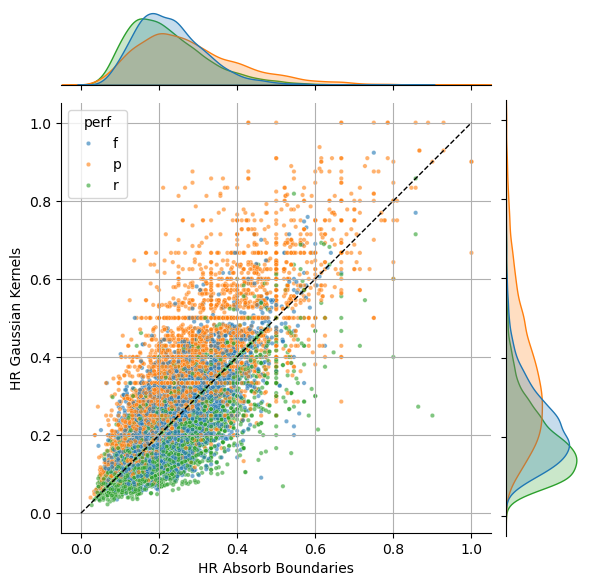

In [18]:
sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="hr_absorb", y="hr_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="hr_absorb", y="hr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default"'), 
    x="hr_absorb", y="hr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


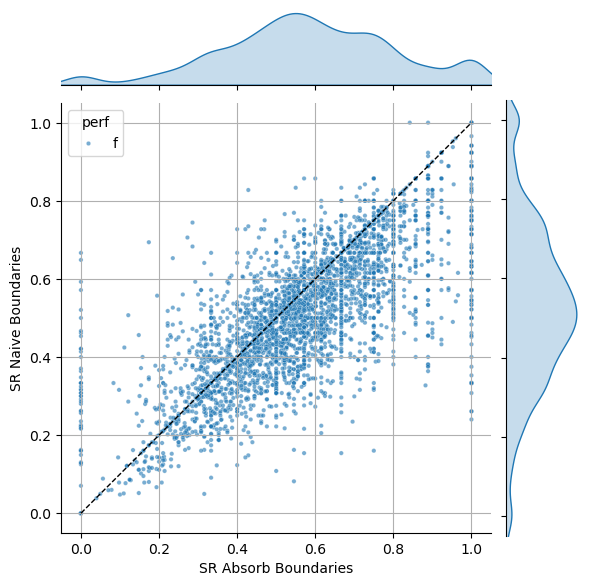

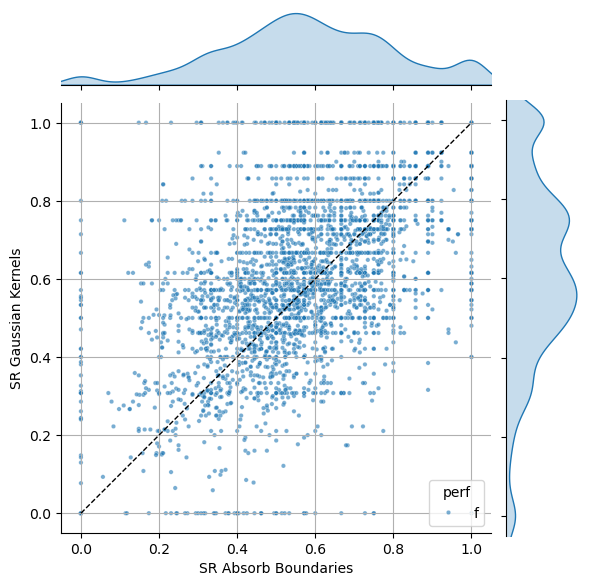

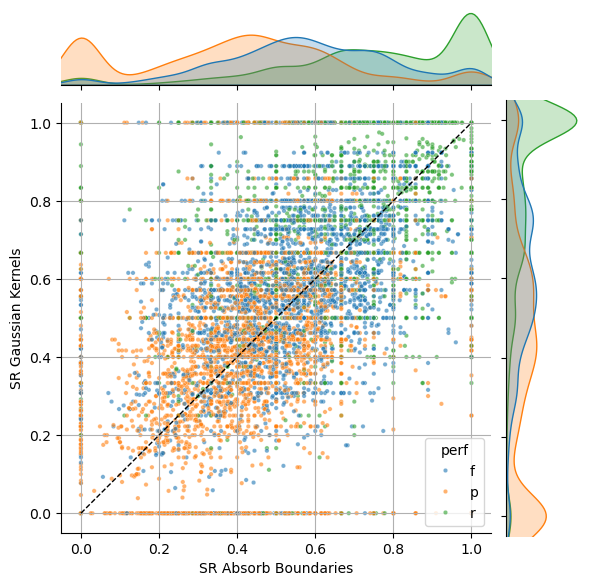

In [19]:
sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="sr_absorb", y="sr_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default" and perf == "f"'), 
    x="sr_absorb", y="sr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "0.5" and depth == "default"'), 
    x="sr_absorb", y="sr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


## Figure 4: See mono casting's effect on B measure, with window = 3 sec

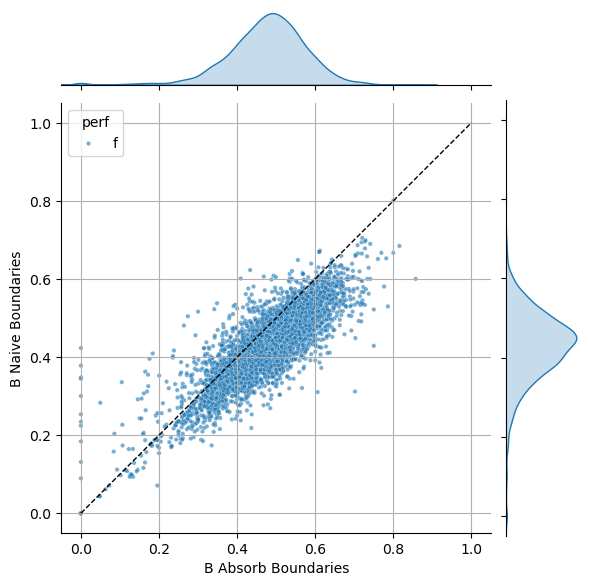

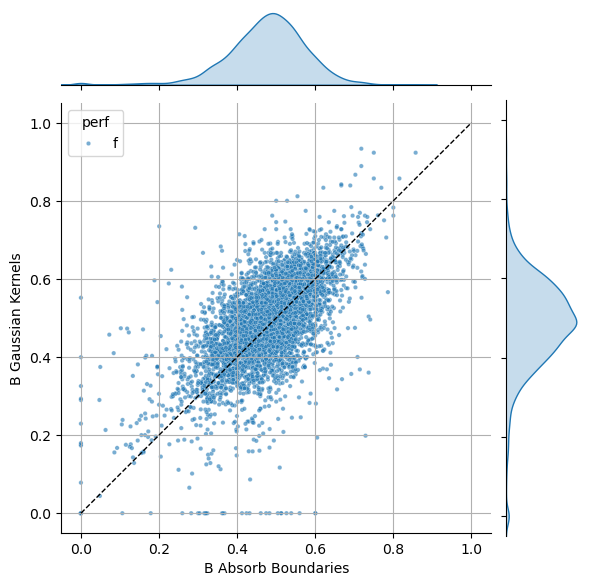

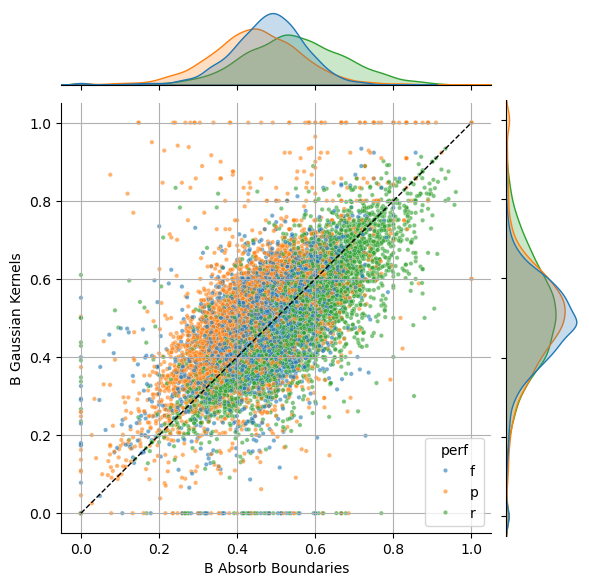

In [20]:
sns.jointplot(
    data=df.query('window == "3" and depth == "default" and perf == "f"'), 
    x="b_absorb", y="b_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "default" and perf == "f"'), 
    x="b_absorb", y="b_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "default"'), 
    x="b_absorb", y="b_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


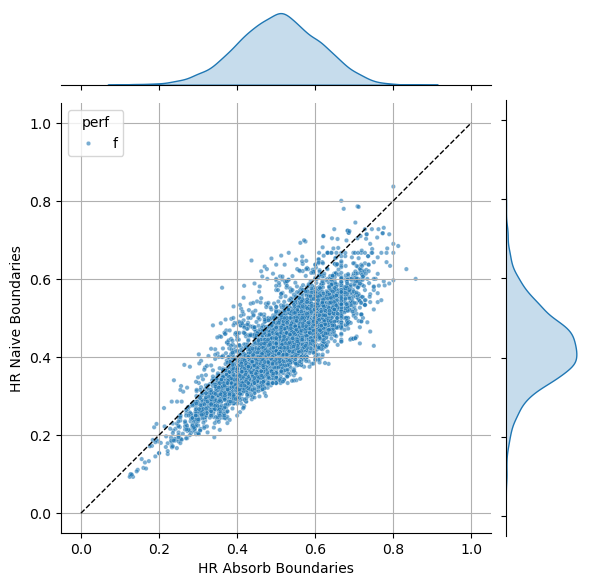

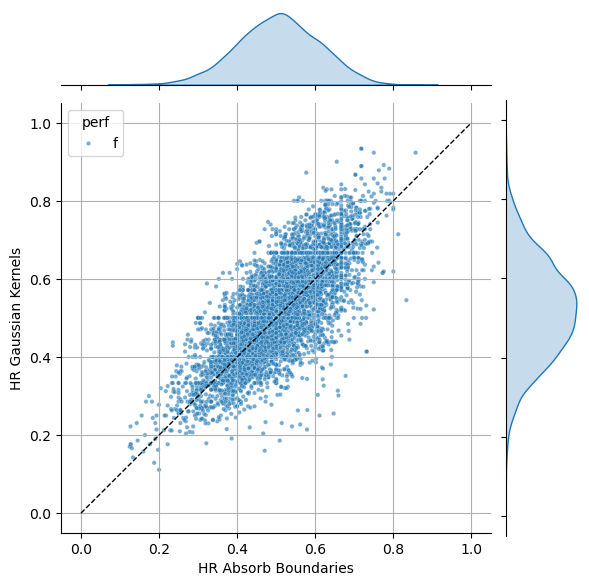

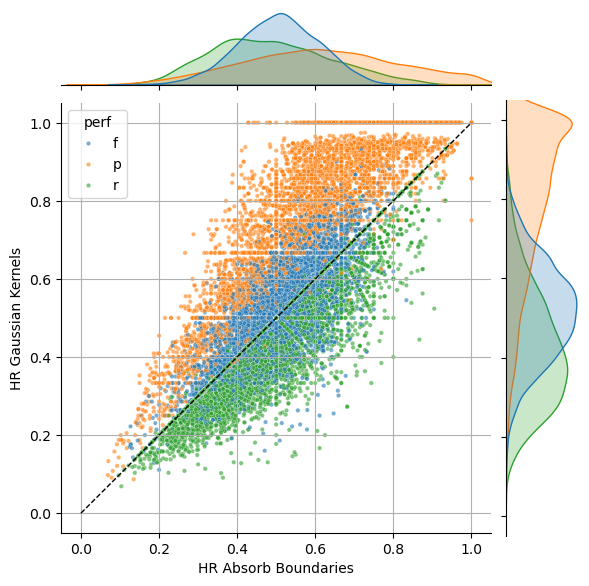

In [21]:
sns.jointplot(
    data=df.query('window == "3" and depth == "default" and perf == "f"'), 
    x="hr_absorb", y="hr_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "default" and perf == "f"'), 
    x="hr_absorb", y="hr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "default"'), 
    x="hr_absorb", y="hr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


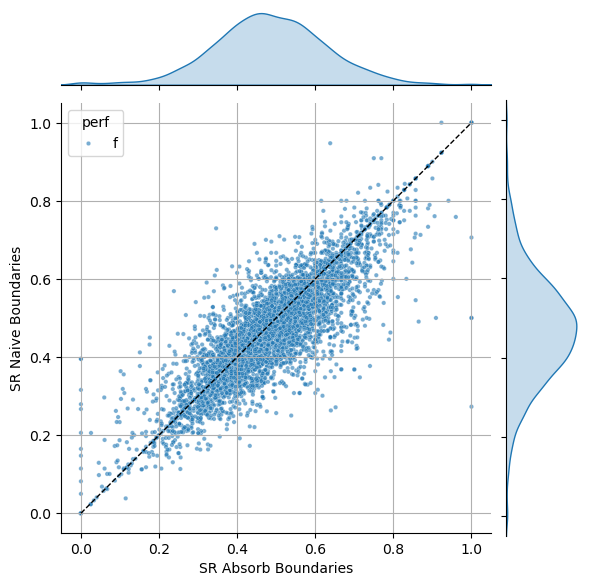

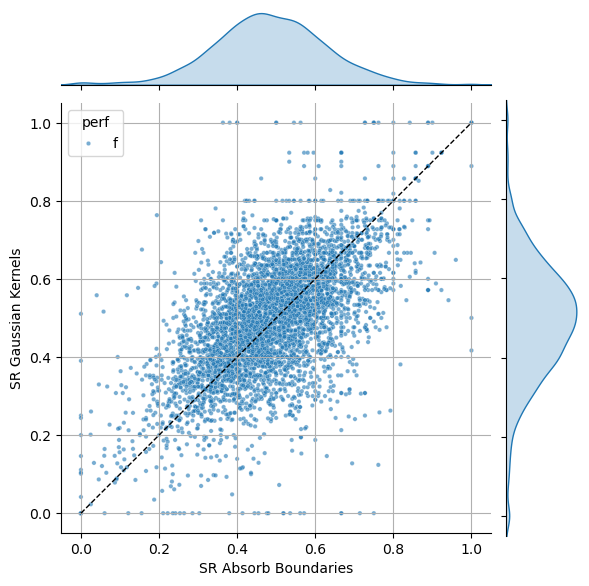

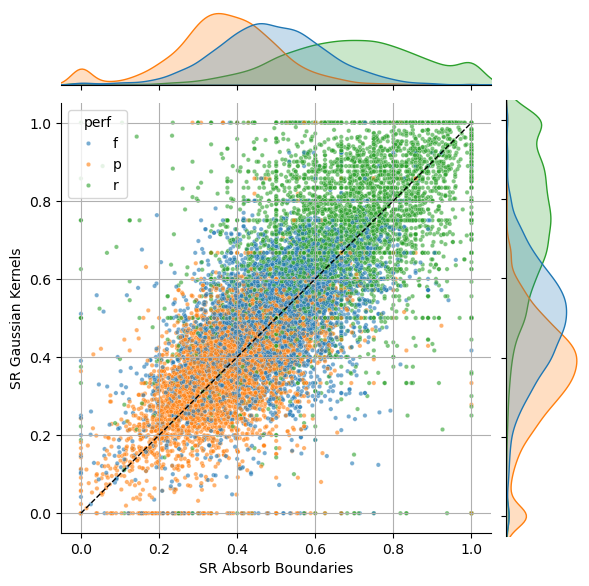

In [22]:
sns.jointplot(
    data=df.query('window == "3" and depth == "default" and perf == "f"'), 
    x="sr_absorb", y="sr_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "default" and perf == "f"'), 
    x="sr_absorb", y="sr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "default"'), 
    x="sr_absorb", y="sr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


## Figure 5:  B measure, with window = 3 sec and squash to 3 layers

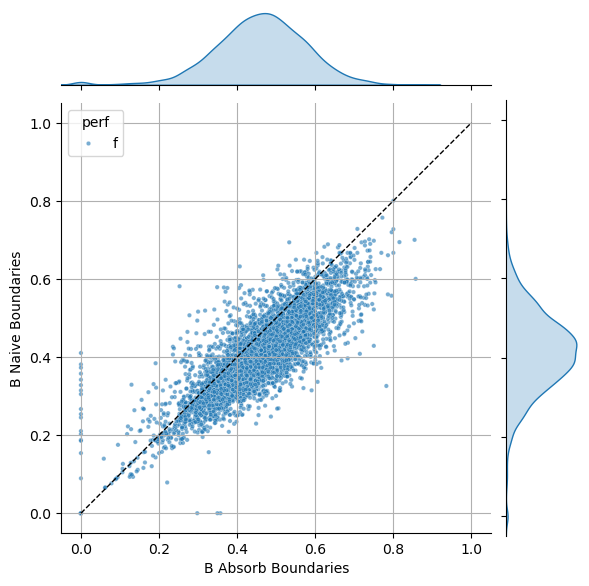

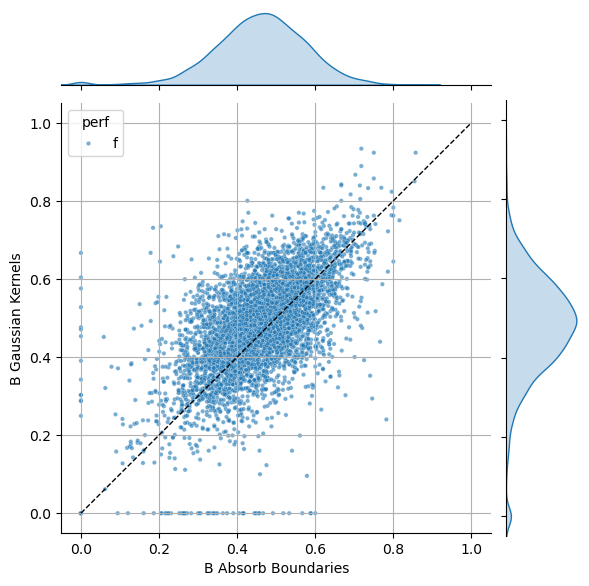

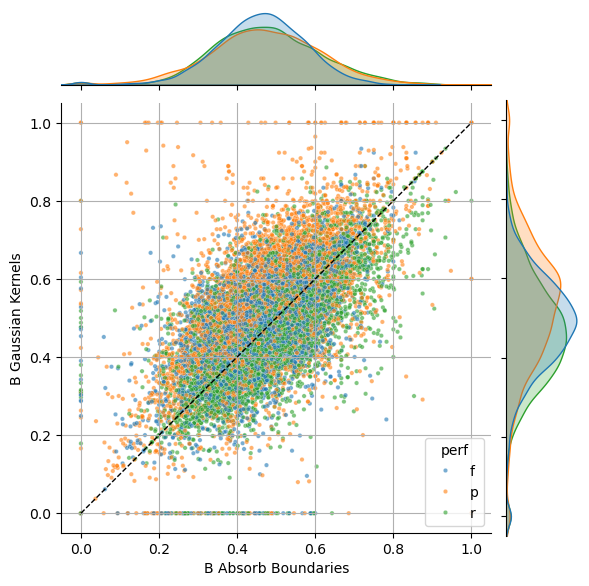

In [24]:
sns.jointplot(
    data=df.query('window == "3" and depth == "3" and perf == "f"'), 
    x="b_absorb", y="b_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "3" and perf == "f"'), 
    x="b_absorb", y="b_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "3"'), 
    x="b_absorb", y="b_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B Absorb Boundaries", ylabel="B Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


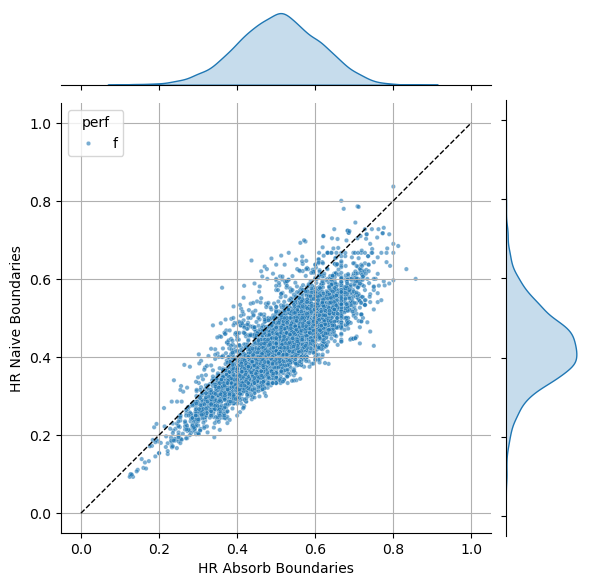

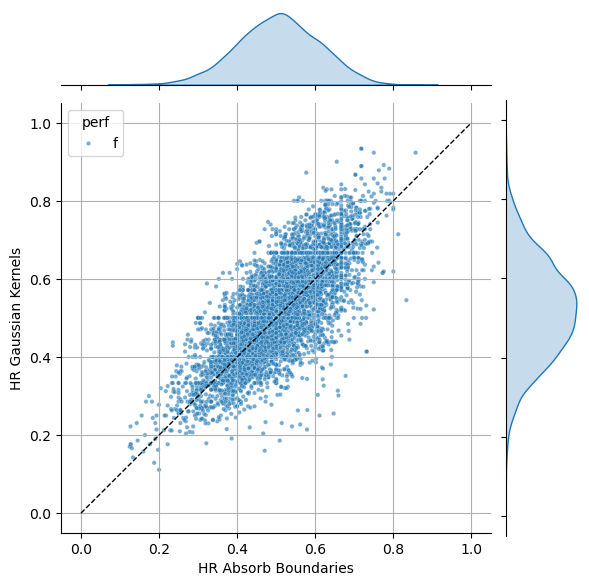

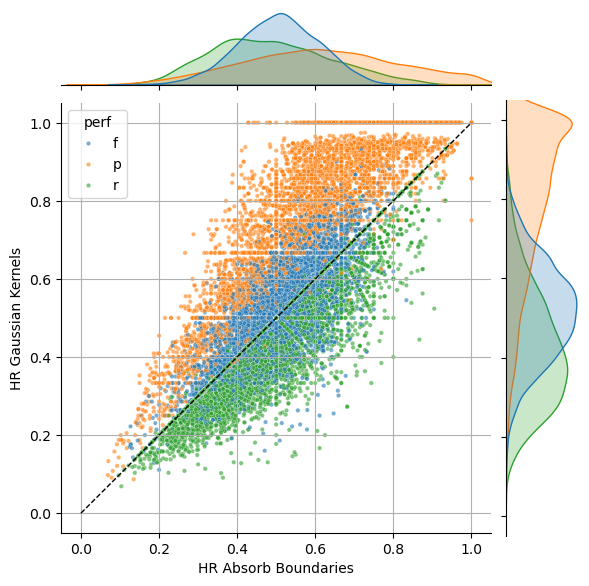

In [25]:
sns.jointplot(
    data=df.query('window == "3" and depth == "3" and perf == "f"'), 
    x="hr_absorb", y="hr_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "3" and perf == "f"'), 
    x="hr_absorb", y="hr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "3"'), 
    x="hr_absorb", y="hr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="HR Absorb Boundaries", ylabel="HR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


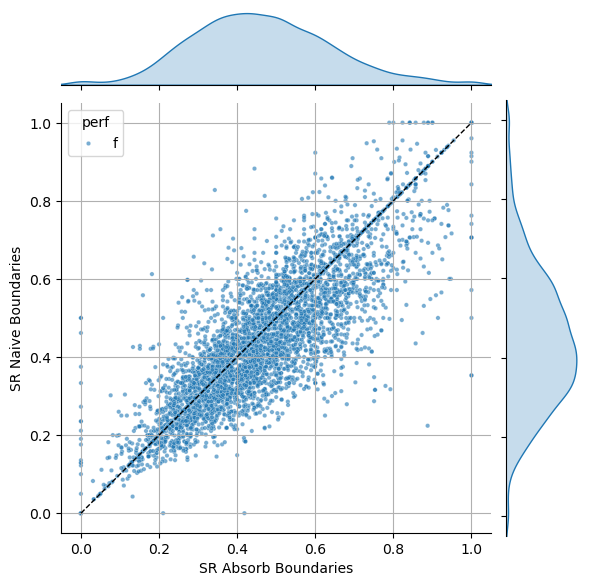

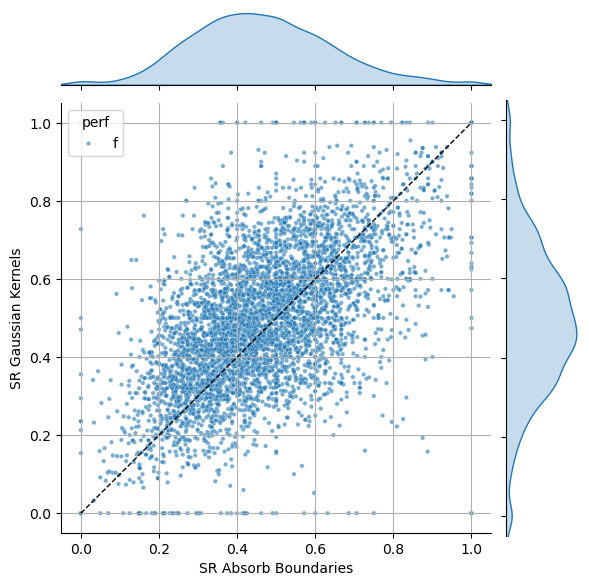

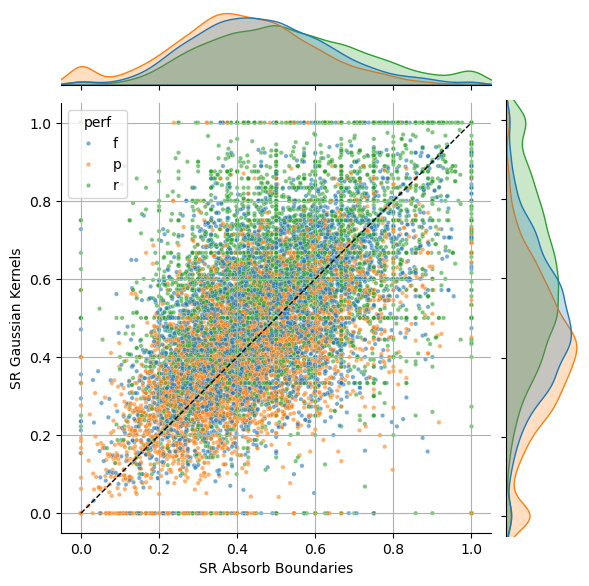

In [32]:
sns.jointplot(
    data=df.query('window == "3" and depth == "3" and perf == "f"'), 
    x="sr_absorb", y="sr_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Naive Boundaries")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "3" and perf == "f"'), 
    x="sr_absorb", y="sr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()

sns.jointplot(
    data=df.query('window == "3" and depth == "3"'), 
    x="sr_absorb", y="sr_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="SR Absorb Boundaries", ylabel="SR Gaussian Kernels")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


## Drafts:

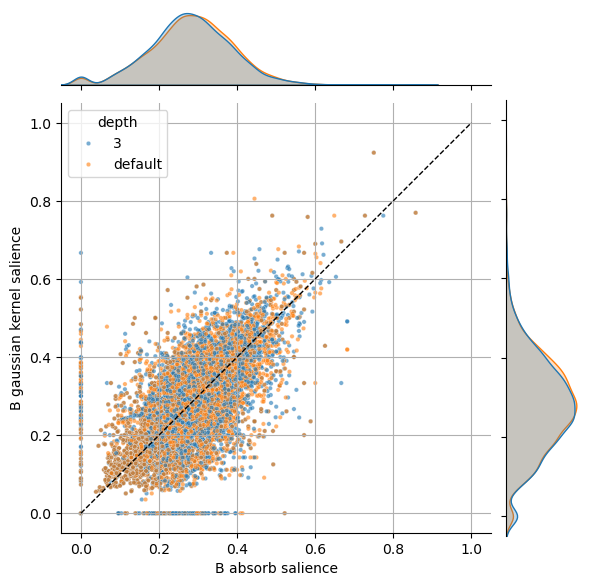

In [27]:
sns.jointplot(
    data=df.query('window == "0.5" and perf == "f"'), 
    x="b_absorb", y="b_bsc", 
    hue="depth", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B absorb salience", ylabel="B gaussian kernel salience")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


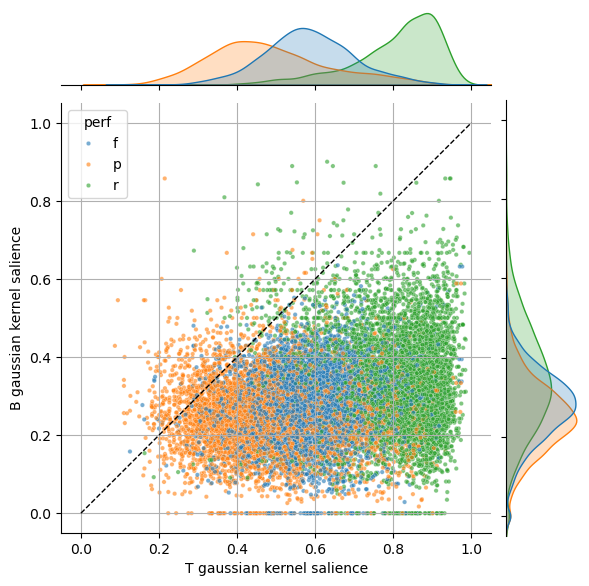

In [28]:
sns.jointplot(
    data=df.query('depth == "default" and window == "0.5"').fillna(0), 
    x="t_naive", y="b_naive", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="T gaussian kernel salience", ylabel="B gaussian kernel salience")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


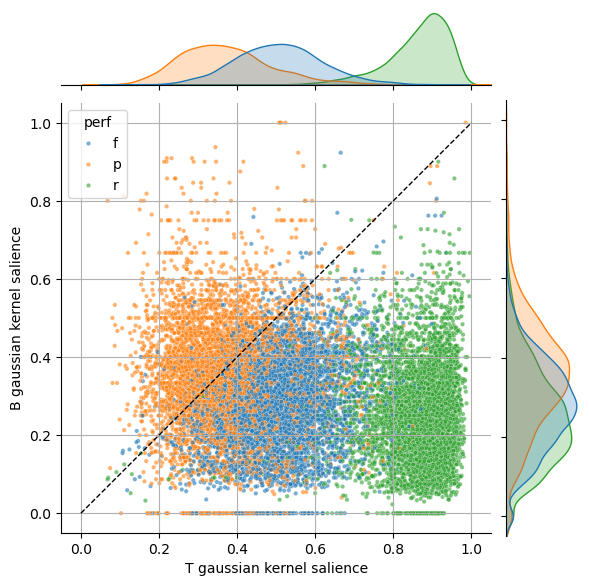

In [29]:
sns.jointplot(
    data=df.query('depth == "default" and window == "0.5"').fillna(0), 
    x="t_bsc", y="b_bsc", 
    hue="perf", 
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="T gaussian kernel salience", ylabel="B gaussian kernel salience")
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
plt.show()


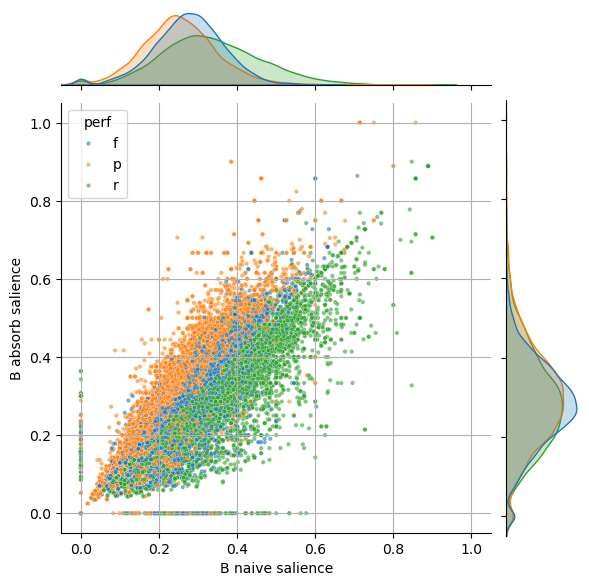

In [30]:

sns.jointplot(
    data=df.query('window == "0.5"'), 
    x="b_naive", y="b_absorb", 
    hue="perf", 
    # kind='kde')
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B naive salience", ylabel="B absorb salience")
plt.show()


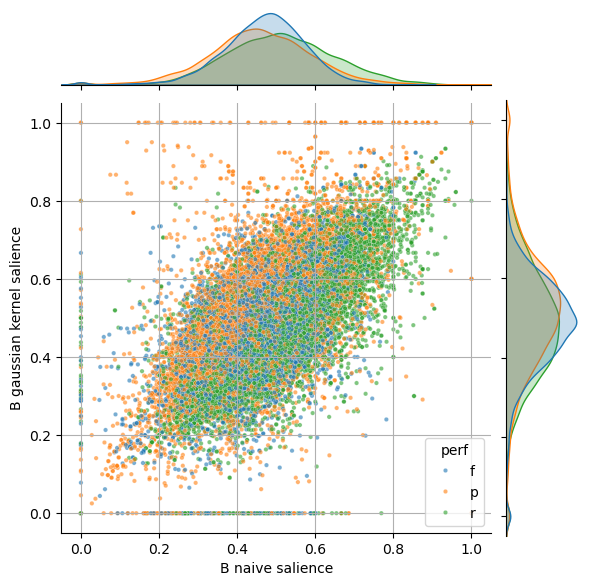

In [31]:

sns.jointplot(
    data=df.query('window == "3"'), 
    x="b_absorb", y="b_bsc", 
    hue="perf", 
    # kind='kde')
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B naive salience", ylabel="B gaussian kernel salience")
plt.show()


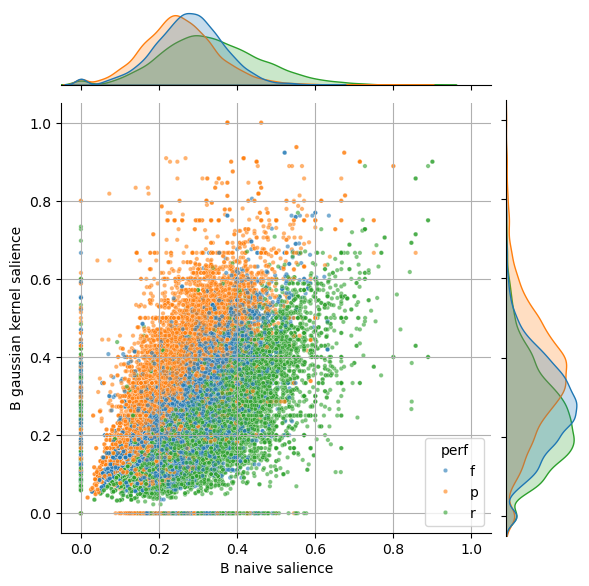

In [5]:
sns.jointplot(
    data=df.query('window == "0.5"'), 
    x="b_naive", y="b_bsc", 
    hue="perf", 
    # kind='kde')
    s=10, alpha=0.6, marker='o')
plt.grid(True)
plt.gca().set(
    aspect='equal', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    xlabel="B naive salience", ylabel="B gaussian kernel salience")
plt.show()


In [10]:
df.query('perf == "f"')

tid window perf  hr_naive_default  hr_naive_3  hr_absorb_default  \
0       10    0.5    f          0.262295    0.262295           0.262295   
6      100    0.5    f          0.222222    0.222222           0.222222   
12    1000    0.5    f          0.135135    0.135135           0.135135   
18    1002    0.5    f          0.237624    0.237624           0.237624   
24    1003    0.5    f          0.297872    0.297872           0.297872   
...    ...    ...  ...               ...         ...                ...   
8058   995    0.5    f          0.151659    0.151659           0.151659   
8064   996    0.5    f          0.300000    0.300000           0.300000   
8070   997    0.5    f          0.215054    0.215054           0.215054   
8076   998    0.5    f          0.177419    0.177419           0.177419   
8082   999    0.5    f          0.145455    0.145455           0.145455   

      hr_absorb_3  hr_bsc_default  hr_bsc_3  sr_naive_default  ...  \
0        0.262295        0.206897  0.206897          0.684211  ...   
6        0.222222        0.272727  0.272727          0.888889  ...   
12       0.135135        0.100000  0.100000          0.333333  ...   
18       0.237624        0.177778  0.177778          0.772727  ...   
24       0.297872        0.120000  0.120000          0.462810  ...   
...           ...             ...       ...               ...  ...   
8058     0.151659        0.026846  0.026846          0.722892  ...   
8064     0.300000        0.105263  0.105263          0.589474  ...   
8070     0.215054        0.139535  0.139535          0.419355  ...   
8076     0.177419        0.078431  0.078431          0.424242  ...   
8082     0.145455        0.200000  0.200000          0.682927  ...   

      b_absorb_default  b_absorb_3  b_bsc_default   b_bsc_3  t_naive_default  \
0             0.387409    0.387409       0.206897  0.206897         0.476207   
6             0.363636    0.363636       0.428571  0.428571         0.452356   
12            0.000000    0.000000       0.181818  0.181818         0.578091   
18            0.365366    0.365366       0.177778  0.177778         0.566862   
24            0.334328    0.334328       0.120000  0.120000         0.557488   
...                ...         ...            ...       ...              ...   
8058          0.232277    0.232277       0.026846  0.026846         0.434568   
8064          0.410526    0.410526       0.105263  0.105263         0.564695   
8070          0.286396    0.286396       0.139535  0.139535         0.583348   
8076          0.218905    0.218905       0.078431  0.078431         0.378442   
8082          0.240000    0.240000       0.304762  0.304762         0.715245   

      t_naive_3  t_absorb_default  t_absorb_3  t_bsc_default   t_bsc_3  
0      0.432805          0.432805    0.432805       0.188618  0.188394  
6      0.479907          0.479907    0.479907       0.403539  0.403539  
12     0.636845          0.636845    0.636845       0.511325  0.511193  
18     0.525989          0.525989    0.525989       0.469778  0.469535  
24     0.556728          0.556728    0.556728       0.412091  0.411862  
...         ...               ...         ...            ...       ...  
8058   0.451928          0.451928    0.451928       0.197793  0.198399  
8064   0.576125          0.576125    0.576125       0.380661  0.380080  
8070   0.567783          0.567783    0.567783       0.459079  0.458540  
8076   0.353313          0.353313    0.353313       0.168023  0.167960  
8082   0.683774          0.683774    0.683774       0.717181  0.717181  

[1348 rows x 27 columns]

In [22]:
df.query('perf == "f"').sort_values(by="b_naive_default", ascending=False).head(10)

tid window perf  hr_naive_default  hr_naive_3  hr_absorb_default  \
3603  1655      3    f          0.727273    0.727273           0.727273   
4833   404      3    f          0.777778    0.777778           0.777778   
6783   759      3    f          0.758621    0.758621           0.758621   
2193  1399      3    f          0.755556    0.755556           0.755556   
7377   869      3    f          0.750000    0.750000           0.750000   
6309   666      3    f          0.571429    0.571429           0.571429   
3909   235      3    f          0.642857    0.642857           0.642857   
6771   757      3    f          0.720000    0.720000           0.720000   
3483  1634      3    f          0.687500    0.687500           0.687500   
3297  1600      3    f          0.606061    0.606061           0.606061   

      hr_absorb_3  hr_bsc_default  hr_bsc_3  sr_naive_default  ...  \
3603     0.727273        0.727273  0.727273          0.842105  ...   
4833     0.777778        0.777778  0.777778          0.000000  ...   
6783     0.758621        0.758621  0.758621          0.000000  ...   
2193     0.755556        0.755556  0.755556          0.759036  ...   
7377     0.750000        0.750000  0.750000          0.000000  ...   
6309     0.571429        0.571429  0.571429          1.000000  ...   
3909     0.642857        0.642857  0.642857          0.818182  ...   
6771     0.720000        0.720000  0.720000          0.000000  ...   
3483     0.687500        0.687500  0.687500          0.750000  ...   
3297     0.606061        0.606061  0.606061          0.820513  ...   

      b_absorb_default  b_absorb_3  b_bsc_default   b_bsc_3  t_naive_default  \
3603          0.780488    0.780488       0.780488  0.780488         0.777225   
4833          0.777778    0.777778       0.777778  0.777778         0.798428   
6783          0.758621    0.758621       0.758621  0.758621         0.662146   
2193          0.757292    0.757292       0.757292  0.757292         0.678794   
7377          0.750000    0.750000       0.750000  0.750000         0.456448   
6309          0.727273    0.727273       0.727273  0.727273         0.467591   
3909          0.720000    0.720000       0.720000  0.720000         0.773129   
6771          0.720000    0.720000       0.720000  0.720000         0.542260   
3483          0.717391    0.717391       0.717391  0.717391         0.679817   
3297          0.697168    0.697168       0.697168  0.697168         0.739050   

      t_naive_3  t_absorb_default  t_absorb_3  t_bsc_default   t_bsc_3  
3603   0.777225          0.777225    0.777225       0.777225  0.777225  
4833   0.798428          0.798428    0.798428       0.798683  0.798683  
6783   0.662146          0.662146    0.662146       0.662671  0.663242  
2193   0.678794          0.678794    0.678794       0.679281  0.679908  
7377   0.456448          0.456448    0.456448       0.456448  0.456448  
6309   0.467591          0.467591    0.467591       0.470602  0.474317  
3909   0.773129          0.773129    0.773129       0.774610  0.776415  
6771   0.542260          0.542260    0.542260       0.543456  0.544702  
3483   0.679817          0.679817    0.679817       0.679103  0.678401  
3297   0.739050          0.739050    0.739050       0.738670  0.738298  

[10 rows x 27 columns]

In [23]:
refs, ests = bnl.fio.salami_annos(1655)

(<Figure size 500x130 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

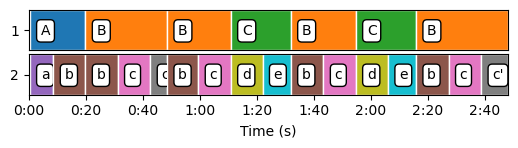

In [32]:
ref = list(refs.values())[0]
ref.plot()

(<Figure size 500x530 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

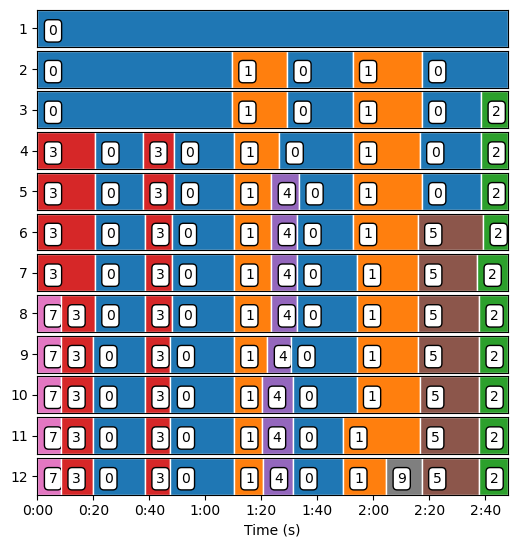

In [45]:
ests['mu1_gamma9'].plot()

(<Figure size 500x490 with 11 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>],
       dtype=object))

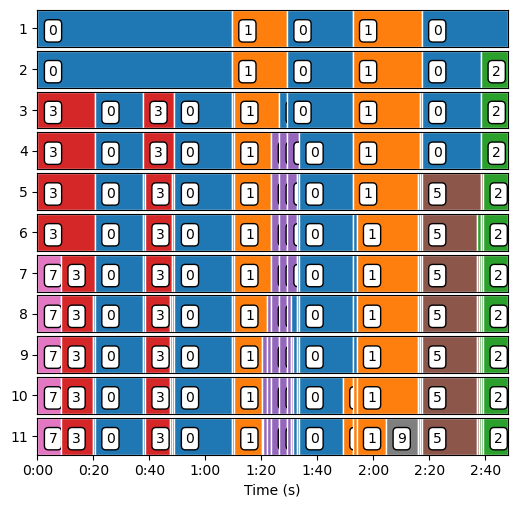

In [42]:
est = bnl.mc.force_mono_B(ests['mu1_gamma9'], absorb_window=0)
bnl.mc.squash_levels(est, max_depth=None).plot()

(<Figure size 500x490 with 11 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>],
       dtype=object))

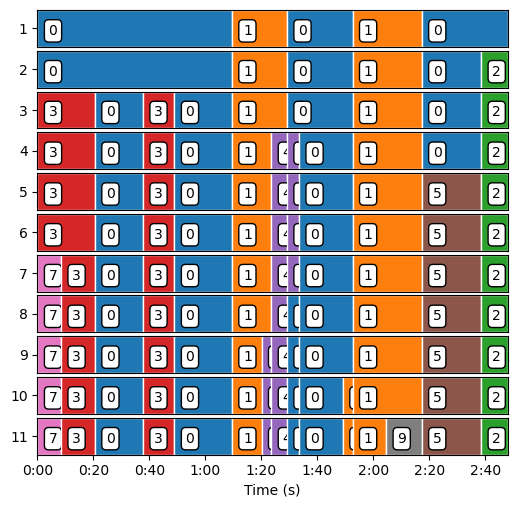

In [52]:
est = bnl.mc.force_mono_B(ests['mu1_gamma9'], absorb_window=3)
bnl.mc.squash_levels(est, max_depth=None).plot()

(<Figure size 500x170 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

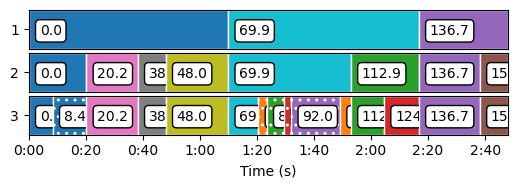

In [53]:
bnl.H(ests['mu1_gamma9'].decode_B(sr=10, bw=1, depth=3)).plot()

In [34]:
bnl.mtr.bmeasure(est.itvls,  ref.itvls,)

prec    recall        f1
hr  0.388889  0.304348  0.341463
sr  0.833333  0.500000  0.625000
b   0.530303  0.378378  0.441640

In [2]:
refs, ests = bnl.fio.salami_annos(384)

(<Figure size 500x490 with 11 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>],
       dtype=object))

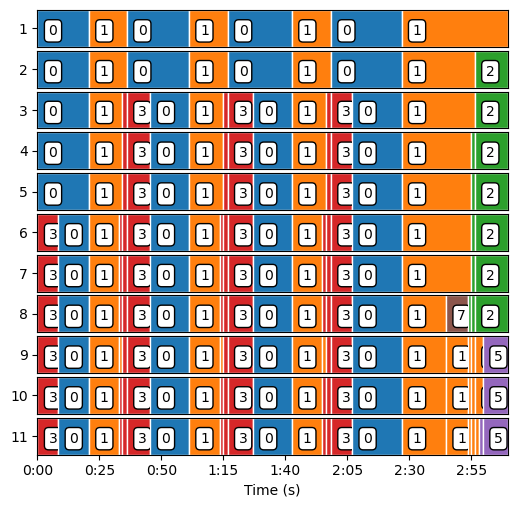

In [30]:
est = bnl.mc.force_mono_B(ests['mu1_gamma9'], absorb_window=1)
bnl.mc.squash_levels(est, depth=None).plot()

(<Figure size 500x170 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

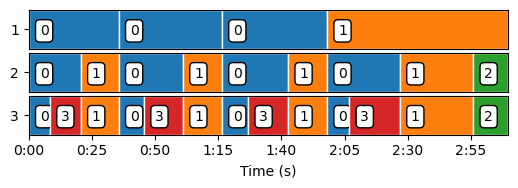

In [27]:
bsc_est = est.decode(sr=5, bw=1, depth=3)
bsc_est.plot()

(<Figure size 500x170 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

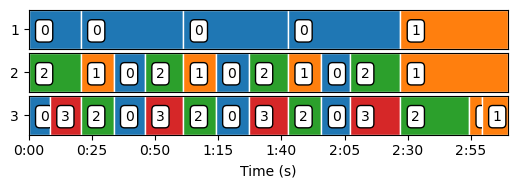

In [28]:
bsc_est = ests['mu1_gamma9'].decode(sr=5, bw=1, depth=3)
bsc_est.plot()